# Economic Instability and Investment Activity in Bitcoin

### by Achal Srinivasan and Corrin Fosmire

## Section 1: Setting up Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import datetime as dt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

First, we will design an API to fetch data on a given metric for a provided country from a REST endpoint provided by the International Monetary Fund (IMF).

In [3]:
def generate_data(country_abbr="US", metric="PXP_IX", resolution="M", start=2009, end=2017):
    """ Retrieves data for given metric and country.
    Args:
        country_abbr: the abbreviation for the country, default to the United States (US)
        metric: the economic metric of interest, default to the Export Price Index (PXP_IX)
        resolution: the timeframe to sample on, default to monthly (M)
        start: year to start collection
        end: year to stop collection
    Output:
        df: a Pandas Dataframe containing the IMF data
    """
    data = requests.get("http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/"+resolution+"."+country_abbr+"."+metric+".?startPeriod="+str(start)+"&endPeriod="+str(end)).json()
    df = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    df = df.rename(index=str, columns={"@OBS_VALUE" : country_abbr+"."+metric, "@TIME_PERIOD" : "date"})
    return df

We now load the data for economic health for a set of countries. These correspond to the United States, Korea, Japan, and Russia.

In [ ]:
countries = ["US", "KR", "JP", "RU"]

We choose relevant metrics to gauge economic health / stability. These correspond to the Employment (`LE_IX`), the Consumer Price Index (`PCPI_IX`) and the domestic currency in USD (`ENDE_XDC_USD_RATE`).

In [ ]:
metrics = ["LE_IX", "PCPI_IX", "ENDE_XDC_USD_RATE"]

In [18]:
# Inspect data.
generate_data(country_abbr="KR",metric="LE_IX").head()

,KR.LE_IX,date
0,95.9151326814698,2009-01
1,95.4095737874995,2009-02
2,96.9304114479616,2009-03
3,98.6559692531425,2009-04
4,99.4640312877847,2009-05


We define an API for creating an exhaustive dataset by iterating over the countries and the metrics of interest noted above.

In [5]:
def make_dataset(countries, metrics):
    """ Initialize and populate a dataset given a list of countries and a list of metrics.
    Args:
        countries: a list of country codes
        metrics: a list of IFS codes corresponding to metrics
    Output:
        full_data: a dataframe populated with the countries and their metrics
    """
    empty = True
    full_data = None
    for country in countries:
        for metric in metrics:
            if empty:
                full_data = generate_data(country_abbr=country, metric=metric)
                empty = False
            else:
                metric_data = generate_data(country_abbr=country, metric=metric)
                full_data = full_data.merge(metric_data, on="date")
        time.sleep(5) # avoid throttling
    return full_data

We call the `make_dataset` method to initialize our dataset.


In [6]:
financial_data = make_dataset(countries, metrics)

In [7]:
# Delete status variables that are unimportant.
financial_data = financial_data[list(filter(lambda a: not a[0] == "@", list(financial_data.columns.values)))]

In [8]:
# Since data is collected on a monthly basis, we assign the values to the first of the month.
financial_data["date"] = financial_data["date"] + "-01"

In [9]:
# Load the dataset: this is a CSV containing the history of market cap for Bitcoin.
btc_data = pd.read_csv("btc.csv")

# Ensure that there are no NaN values.
btc_data = btc_data[btc_data["marketcap(USD)"] != np.nan]

# Choose the columns of interest and extract them into a smaller dataframe.
mc_date = btc_data[["date","marketcap(USD)"]]

# Normalize the format of the timestamps on the data to be in datetime format.
mc_date['date'] = pd.to_datetime(mc_date['date'])
mc_date = mc_date.dropna()
mc_date['date'] = mc_date['date'].dt.strftime(date_format="%Y-%m-%d")
mc_date.head()

/Users/achal/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,date,marketcap(USD)
1570,2013-04-28,1.500656e+09
1571,2013-04-29,1.491703e+09
1572,2013-04-30,1.598310e+09
1573,2013-05-01,1.543334e+09
1574,2013-05-02,1.292577e+09


We left join the Bitcoin price history dataframe with the economic health metrics dataframe we generated earlier on the date column. 

In [10]:
# Perform left join.
combined = mc_date.merge(financial_data, on="date", how="left")
combined['date'] = pd.to_datetime(combined['date'])

# We ensure that the dataframe is limited to only entries until June 6, 2016.
combined = combined[combined['date'] < pd.to_datetime('2016-06-01')]

# We convert data to numeric form for the purposes of interpolation and inference.
for country in countries:
    for metric in metrics:
        combined[country+"."+metric] = pd.to_numeric(combined[country+"."+metric])

We interpolate economic data between months to obtain an adequate sample size for our data and to resolve the difference in observation frequency between the market cap and the economic data. It seems reasonable to assume that economic data is not extremely volatile within a month, so we linearly interpolate the data points to produce reasonable estimates for every day, instead of every month, of the year. This makes training and testing much more effective.

In [ ]:
combined = combined.interpolate(method='linear').dropna()

In [19]:
# We inspect the head of the dataframe to ensure its form.
combined.head()

,date,marketcap(USD),US.LE_IX,US.PCPI_IX,US.ENDE_XDC_USD_RATE,KR.LE_IX,KR.PCPI_IX,KR.ENDE_XDC_USD_RATE,JP.LE_IX,JP.PCPI_IX,JP.ENDE_XDC_USD_RATE,RU.LE_IX,RU.PCPI_IX,RU.ENDE_XDC_USD_RATE
3,2013-05-01,1.543334e+09,103.860155,106.828307,1.0,106.564325,107.468047,1129.700000,100.886501,99.7669,101.030000,102.734328,120.884098,31.589300
4,2013-05-02,1.292577e+09,103.869643,106.836577,1.0,106.574405,107.463831,1130.096774,100.883428,99.7669,100.936774,102.720462,120.900475,31.625419
5,2013-05-03,1.180430e+09,103.879130,106.844847,1.0,106.584486,107.459615,1130.493548,100.880355,99.7669,100.843548,102.706596,120.916853,31.661539
6,2013-05-04,1.090276e+09,103.888618,106.853116,1.0,106.594566,107.455399,1130.890323,100.877282,99.7669,100.750323,102.692730,120.933230,31.697658
7,2013-05-05,1.255228e+09,103.898105,106.861386,1.0,106.604646,107.451183,1131.287097,100.874209,99.7669,100.657097,102.678864,120.949608,31.733777


In [20]:
# And the tail of the dataframe as well.
combined.tail()

,date,marketcap(USD),US.LE_IX,US.PCPI_IX,US.ENDE_XDC_USD_RATE,KR.LE_IX,KR.PCPI_IX,KR.ENDE_XDC_USD_RATE,JP.LE_IX,JP.PCPI_IX,JP.ENDE_XDC_USD_RATE,RU.LE_IX,RU.PCPI_IX,RU.ENDE_XDC_USD_RATE
1125,2016-05-27,7.071638e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825
1126,2016-05-28,7.377352e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825
1127,2016-05-29,8.228550e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825
1128,2016-05-30,8.245898e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825
1129,2016-05-31,8.336733e+09,109.010305,110.168741,1.0,110.735706,110.717865,1191.7,102.744185,103.600104,111.09,103.450746,161.571897,66.0825


## Section 2: Exploratory Data Analysis

Here, we note that the market capitalization of Bitcoin skyrocketed at the end of 2013, then experienced instability trending downwards until 2015, at which point it began to rebound.

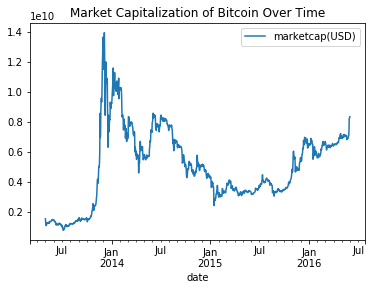

In [13]:
combined.plot(x='date',y='marketcap(USD)', title="Market Capitalization of Bitcoin Over Time")

We plot the inflation rates of four countries known to be home to retail and institutional cryptocurrency investors. We see that Russia experienced a rapid increase in inflation year over year between 2014 and 2016. 

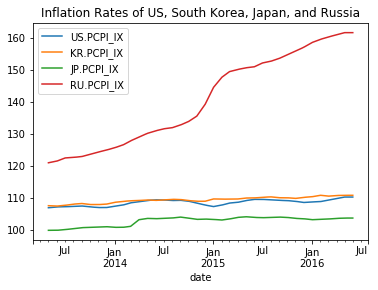

In [14]:
ax = combined.plot(x='date',y='US.PCPI_IX')
combined.plot(x='date',y='KR.PCPI_IX', ax=ax)
combined.plot(x='date',y='JP.PCPI_IX', ax=ax)
combined.plot(x='date',y='RU.PCPI_IX', ax=ax, title="Inflation Rates of US, South Korea, Japan, and Russia")

We plot the employment indexes for the respective countries, and notice cyclical (trending upwards) patterns in Japan, South Korea, and Russia, whereas we see a less unstable trend upwards in the United States. We also notice that all four countries had noticeably low unemployment indices in January 2014. Russia's volatility is clear, but the employment index is not upwards trending.

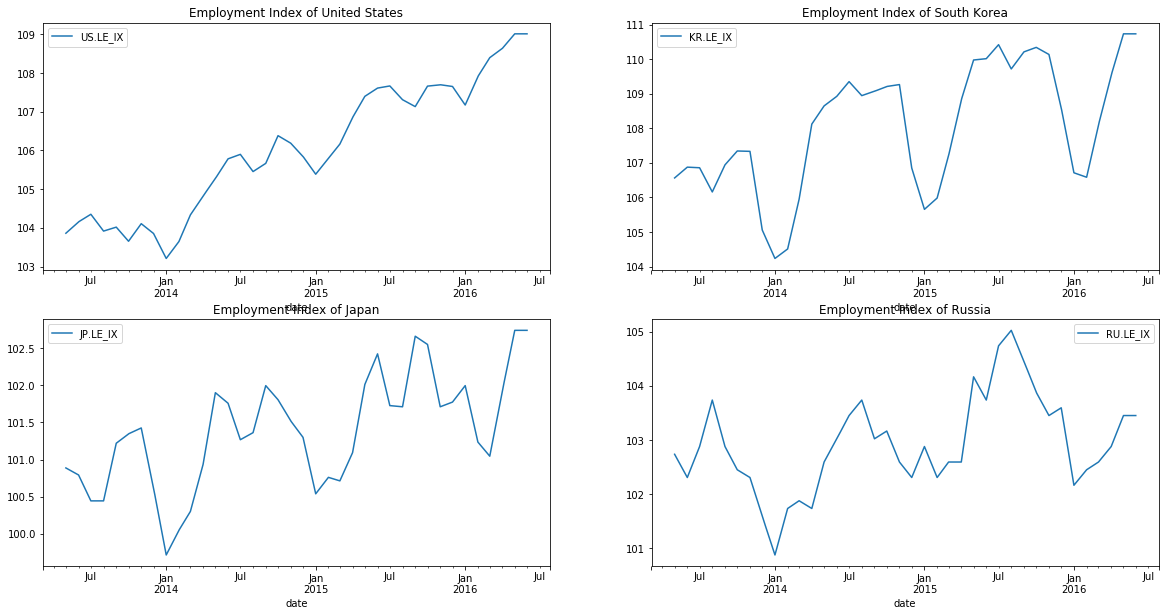

In [15]:
# We modify the figure and plot sizes to create a 2x2.
plt.rcParams['figure.figsize'] = (20,10)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

# Plot.
combined.plot(x='date',y='US.LE_IX', ax=ax1, title="Employment Index of United States")
combined.plot(x='date',y='KR.LE_IX', ax=ax2, title="Employment Index of South Korea")
combined.plot(x='date',y='JP.LE_IX', ax=ax3, title="Employment Index of Japan")
combined.plot(x='date',y='RU.LE_IX', ax=ax4, title="Employment Index of Russia")

The exchange rate of the US Dollar is constant (1:1), hence the horizontal line. All of the other currencies have been devalued relative to the dollar consistently from 2013 to 2016, though the Yen (Japanese currency) has increased in value post-January 2016.

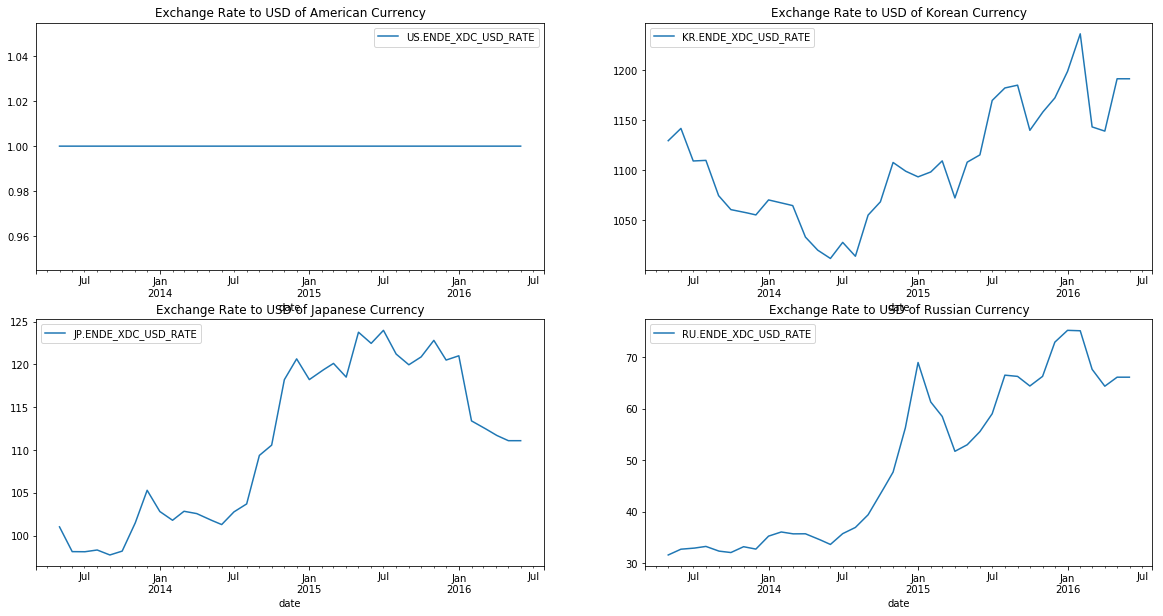

In [14]:
plt.rcParams['figure.figsize'] = (20,10)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

# We plot the relative value of the domestic currency against the US Dollar
# by measuring the exchange rate. 
combined.plot(x='date',y='US.ENDE_XDC_USD_RATE', ax=ax1, title="Exchange Rate to USD of American Currency")
combined.plot(x='date',y='KR.ENDE_XDC_USD_RATE', ax=ax2, title="Exchange Rate to USD of Korean Currency")
combined.plot(x='date',y='JP.ENDE_XDC_USD_RATE', ax=ax3, title="Exchange Rate to USD of Japanese Currency")
combined.plot(x='date',y='RU.ENDE_XDC_USD_RATE', ax=ax4, title="Exchange Rate to USD of Russian Currency")

## Section 3: Modeling

We will build models with and without exogenous regressors to predict the market cap of Bitcoin using the **Facebook Prophet** models.

In [28]:
import fbprophet

We will study the United States, Korea, and Japan — three countries with some of the largest populations of active retail and institutional crypto investors. For metrics of economic activity caused by lack of confidence in domestic markets, we measure employment rates and the consumer price index (an excellent indicator of inflation/deflation).

In [29]:
countries = ["US", "KR", "JP"]
metrics = ["LE_IX", "PCPI_IX"]

We split the dataset into training and testing sets. We will train on data before 2016 (from 2013 to 2015), and predict the first five months of 2016. This time period was after the initial boom of Bitcoin prices, but before the unpredictable media craze that led to a dramatic increase in prices in mid- to late-2017. We note that global markets experienced fluctuations during this time (specifically Korea and Japan), and we hope to find a relationship between employment rates and the CPI as it relates to investment in cryptocurrencies.

In [30]:
cryptoecon_train = combined[combined['date'] < pd.to_datetime('2016-01-01')]
cryptoecon_test = combined[combined['date'] >= pd.to_datetime('2016-01-01')]

In [31]:
# Preparing the Prophet dataframes.
prophet_df = pd.DataFrame(cryptoecon_train)
prophet_df['ds'] = prophet_df['date']
prophet_df['y'] = prophet_df['marketcap(USD)']

prophet_test = pd.DataFrame(cryptoecon_test)
prophet_test['ds'] = prophet_test['date']
prophet_test['y'] = prophet_test['marketcap(USD)']

In [32]:
# Create a model with no exogenous variables.
no_exo_m = fbprophet.Prophet()
no_exo_m.fit(prophet_df)

# Create a model with all exogenous variables.
all_exo_m = fbprophet.Prophet()

for country in countries:
    for metric in metrics:
        all_exo_m.add_regressor(country+"."+metric)

all_exo_m.fit(prophet_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/achal/miniconda3/envs/py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


We are producing two Prophet models: one containing exogenous variables and one not containing exogenous variables. We would like to see that the model containing economic data as a regressor performs better than the one without.

In [33]:
no_exo_preds = no_exo_m.predict(prophet_test)
all_exo_preds = all_exo_m.predict(prophet_test)

Text(0,0.5,'Market Cap (1e10, USD)')

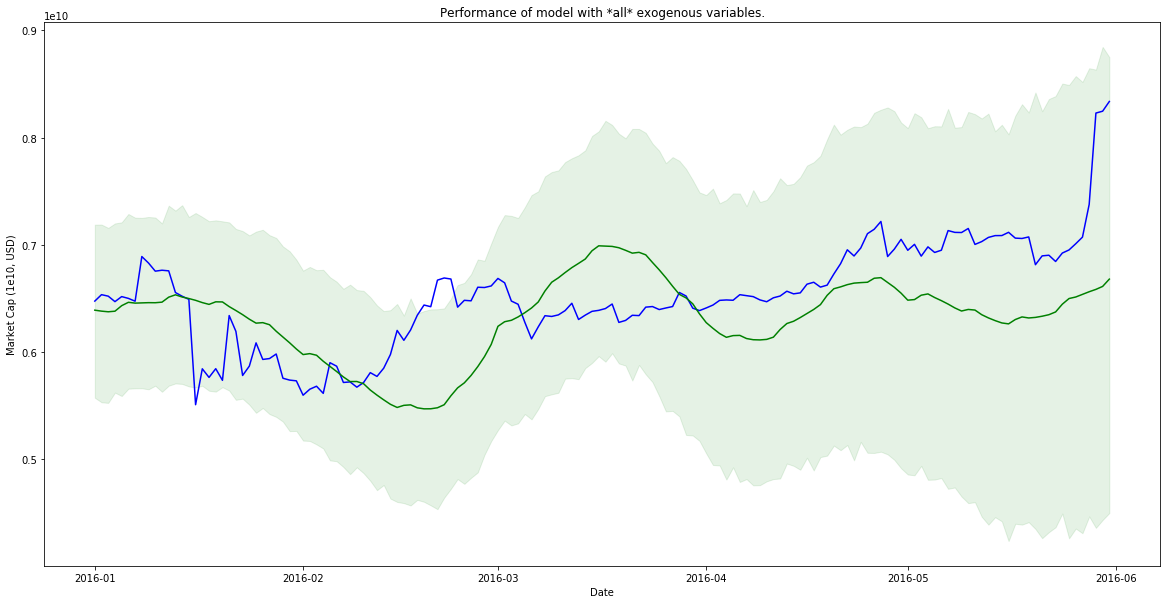

In [36]:
plt.plot(prophet_test['ds'].values, prophet_test['marketcap(USD)'].values, c="b")
plt.plot(prophet_test['ds'].values, all_exo_preds['yhat'].values, c="g")
plt.fill_between(prophet_test['ds'].values, all_exo_preds['yhat_lower'].values, all_exo_preds['yhat_upper'].values,alpha=0.1, color="g")
plt.title("Performance of model with *all* exogenous variables.")
plt.xlabel("Date")
plt.ylabel("Market Cap (1e10, USD)")

Text(0,0.5,'Market Cap (1e10, USD)')

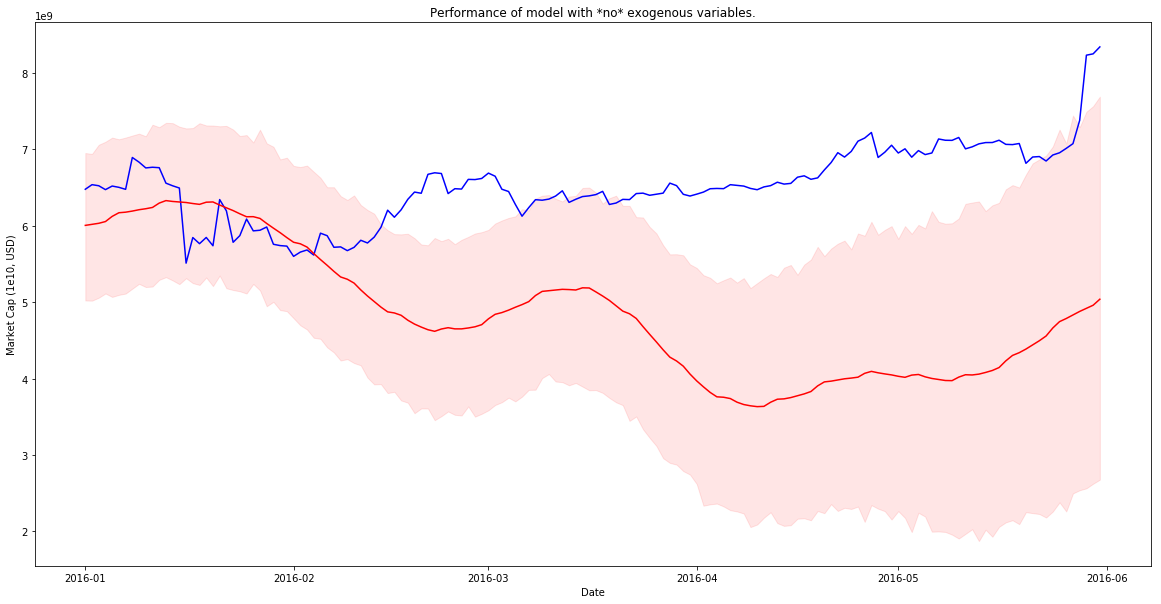

In [38]:
plt.plot(prophet_test['ds'].values, prophet_test['marketcap(USD)'].values, c="b")
plt.plot(prophet_test['ds'].values, no_exo_preds['yhat'].values, c="r")
plt.fill_between(prophet_test['ds'].values, no_exo_preds['yhat_lower'].values, no_exo_preds['yhat_upper'].values,alpha=0.1, color="r")
plt.title("Performance of model with *no* exogenous variables.")
plt.xlabel("Date")
plt.ylabel("Market Cap (1e10, USD)")

Clearly, the model with exogenous regressors is often much closer to the actual market cap of Bitcoin. Additionally, almost every point in the first six months of forecasting is in the prediction interval for the model with exogenous regressors, but roughly half of the time, the true value falls outside the prediction interval for the model with no exogenous regressors. We measure the RMSE of the two models, and notice that the values look quite high — this is beacuse of the scale of the market cap (it's in the tens of billions of dollars). Our model with exogenous regressors predicts a model within just a few standard deviations of the true value quite often.

In [23]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
print("RMSE of no Exogenous Variables Model: \t" + str(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, no_exo_preds['yhat'].values))))
print("RMSE of all Exogenous Variables Model: \t" + str(sqrt(mean_squared_error(prophet_test['marketcap(USD)'].values, all_exo_preds['yhat'].values))))

print(np.mean(np.abs(prophet_test['marketcap(USD)'].values - no_exo_preds['yhat'].values)/prophet_test['marketcap(USD)'].values))
print(np.mean(np.abs(prophet_test['marketcap(USD)'].values - all_exo_preds['yhat'].values)/prophet_test['marketcap(USD)'].values))

RMSE of no Exogenous Variables Model: 	2004137573.1770084
RMSE of all Exogenous Variables Model: 	594966108.1281198
0.25492608879911066
0.07293850517492426


## Section 4: Data Visualization

We will now visualize our data so that we can inspect whether our trained model is able to predict the market capitalization of Bitcoin given information about employment and inflation (measured by the Consumer Price Index) for the countries under analysis.

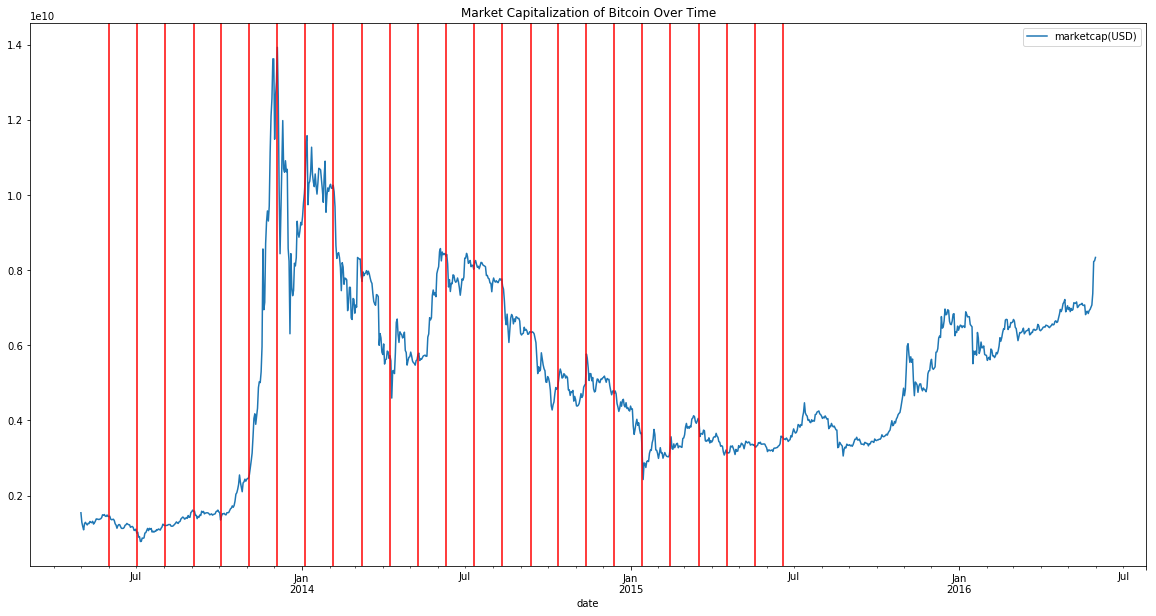

In [39]:
# Create a combined plot with the market capitalization and relevant changepoints.
ax = combined.plot(x='date',y='marketcap(USD)', title="Market Capitalization of Bitcoin Over Time")

for chgpt in all_exo_m.changepoints:
    plt.axvline(x=chgpt, c='r')

The data is partitioned into several parts by the Prophet algorithm, which (in our case) appears to be evenly spaced intervals.

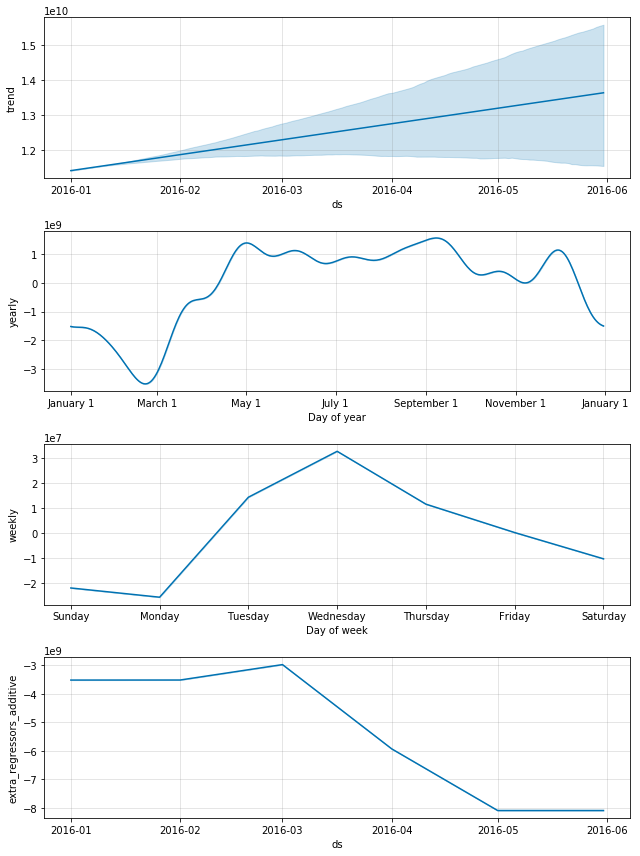

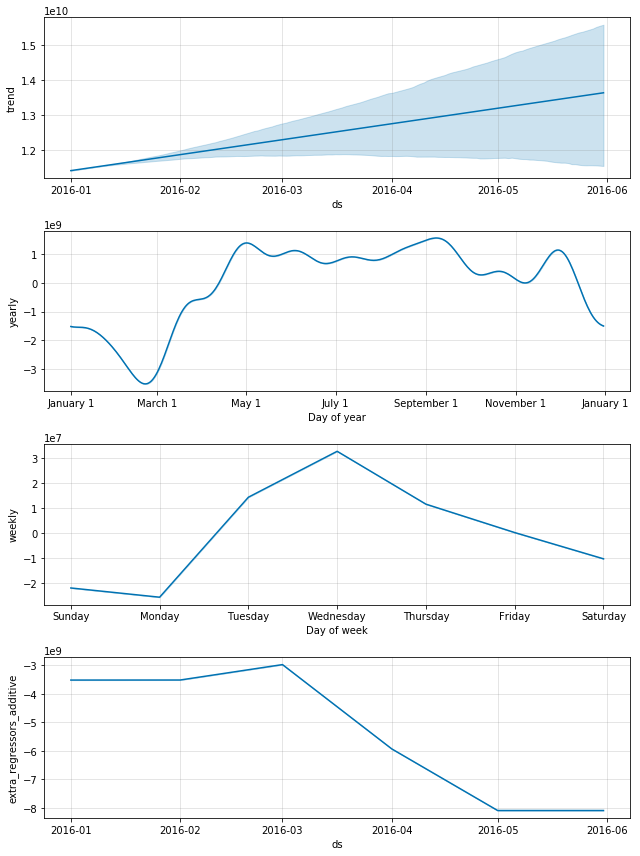

In [42]:
# Inferring how the data is partitioned by Prophet.
all_exo_m.plot_components(all_exo_preds)

There seems to be a fair bit of yearly and weekly seasonality in Bitcoin's market cap, which is definitely surprising. Also, we notice that the role of the exogenous regressors seems to fall noticeably between March and May of 2016.

In [52]:
def plot_forecast(actual, pred, yhat_lower, yhat_upper, title='BTC Actual Market Cap vs Forecasted', 
                  xlabel='Days Since 01/01/2013', ylabel='Bitcoin Market Cap (1e10, USD)', 
                  grid=True, figsize=(15, 10)):
    """ Plot the forecast given observed and predicted values. """
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc=0)
    plt.grid(True)
    
combined['y'] = combined['marketcap(USD)']
combined['ds'] = combined['date']
    
full_preds = all_exo_m.predict(combined)

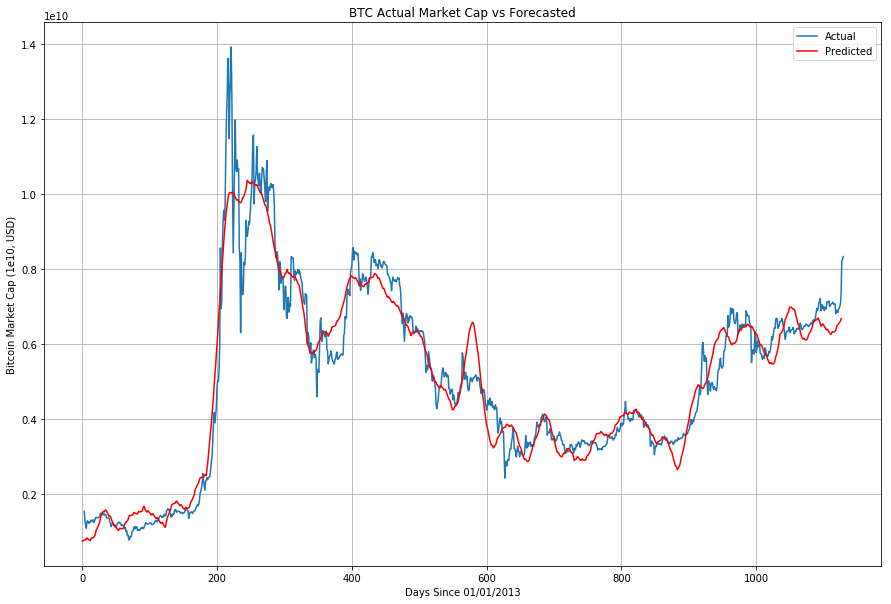

In [53]:
# Plot our model.
plot_forecast(combined['y'], full_preds['yhat'], full_preds['yhat_lower'], full_preds['yhat_upper'])

We can see that the Prophet model fairly accurately predicts BTC's market capitalization for the entire 3-year duration of the data set, although it is less sensitive to sudden changes in prices (i.e. it is not accurate at a level of granularity

In [56]:
# Training curve data.
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) # So we don't get swamped with useless debugging messages...

# Measure MRE.
mean_relative_errs = []
for num_obs in range(10, len(prophet_df['ds']), 10):
    all_exo_red_m = fbprophet.Prophet()
    for country in countries:
        for metric in metrics:
            all_exo_red_m.add_regressor(country+"."+metric)
    all_exo_red_m.fit(prophet_df.tail(num_obs))
    all_exo_preds = all_exo_red_m.predict(prophet_test)
    mean_relative_errs.append(np.mean(np.abs(prophet_test['marketcap(USD)'].values - all_exo_preds['yhat'].values)/prophet_test['marketcap(USD)'].values))

/Users/achal/miniconda3/envs/py36/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
/Users/achal/miniconda3/envs/py36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We plot the MRE (mean relative error) to determine how the value changes given an increasing number of observations. We notice that the MRE does decrease as observations increase, but we see some increases due to changes in market cap that are poorly predicted by our chosen metrics of interest (such as increased media coverage). 

Text(0,0.5,'Mean Relative Error')

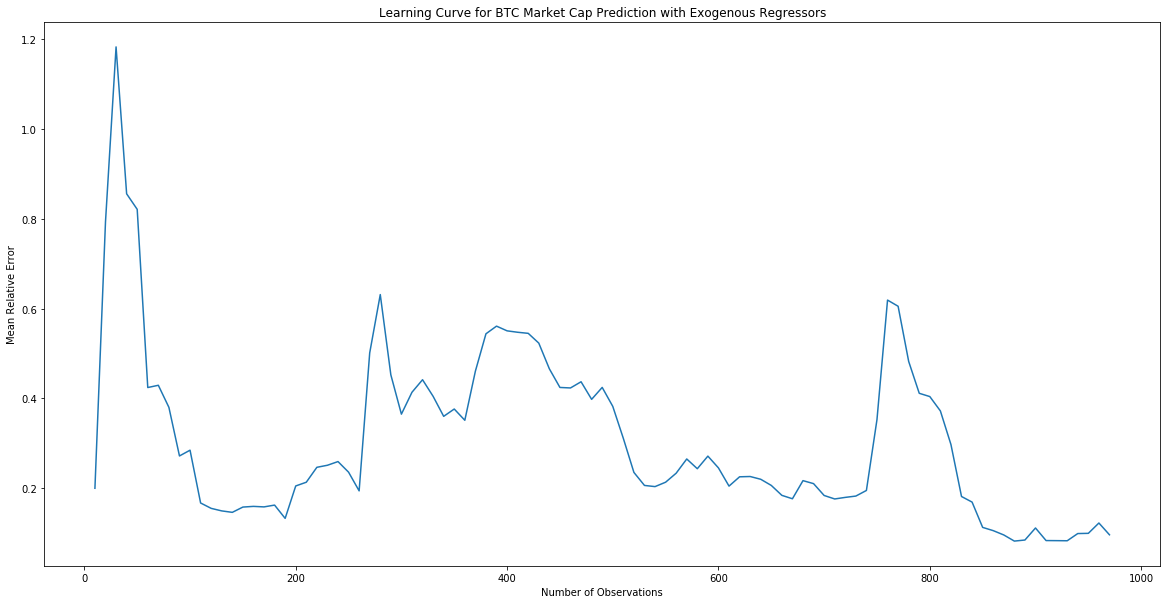

In [57]:
# Plot MRE.
plt.plot(list(range(10, len(prophet_df['ds']), 10)), mean_relative_errs)
plt.title("Learning Curve for BTC Market Cap Prediction with Exogenous Regressors")
plt.xlabel("Number of Observations")
plt.ylabel("Mean Relative Error")